In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torchvision

import matplotlib.pyplot as plt
import numpy as np

# Prepare MNIST dataset

In [2]:
MNIST_mean = 0.1307
MNIST_std = 0.3081

MNIST_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        (MNIST_mean,), (MNIST_std,)
    )
])

MNIST_inverse_transform = torchvision.transforms.Compose([
    torchvision.transforms.Lambda(lambda x: x*MNIST_std + MNIST_mean),
    torchvision.transforms.ToPILImage()
])

mnist_dataset = torchvision.datasets.MNIST(
    './mnist_datset', train=True, download=True, 
    transform=MNIST_transform
)

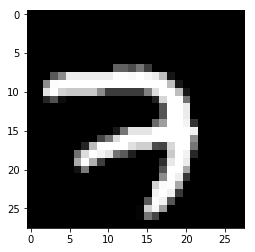

In [29]:
plt.imshow(MNIST_inverse_transform(mnist_dataset[5000][0]), cmap='gray')

# InfoGAN model

In [45]:
class Generator(nn.Module):
    def __init__(self, noise_size):
        super(Generator, self).__init__()
        
        self.main = nn.Sequential(
            
            nn.ConvTranspose2d(noise_size, 512, 4, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(128, 64, 2, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(64, 1, 1, 1, 1, bias=False),
            nn.Tanh()
            #nn.Sigmoid()
        )
        self.noise_size = noise_size
        
    def forward(self, x):
        return self.main(x)
    
class FrontEnd(nn.Module):
    def __init__(self):
        super(FrontEnd, self).__init__()
        
        self.main = nn.Sequential(
            
            nn.Conv2d(1, 64, 1, 1, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64, 128, 2, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
    
    def forward(self, x):
        return self.main(x)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.main = nn.Sequential(
            nn.Conv2d(512, 1, 4, 1, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.main(x)
        #return self.main(x).view(-1, 1)
        return x.view(-1,1)
    
class Q(nn.Module):
    def __init__(self):
        super(Q, self).__init__()
        
        #self.main = nn.Sequential(
        #    nn.Conv2d(1024, 128, 1, bias=False),
        #    nn.ReLU(True),
        #    nn.Conv2d(128, 10, 1)
        #)
        self.main = nn.Sequential(
            nn.Linear(8192, 100, bias=True),
            nn.ReLU(),
            nn.Linear(100, 10, bias=True)
        )
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.main(x).squeeze()

# Train InfoGAN

In [42]:
class Trainer:
    def __init__(self, generator, front_end, discriminator, Q):
        self.generator = generator.cuda()
        self.front_end = front_end.cuda()
        self.discriminator = discriminator.cuda()
        self.Q = Q.cuda()
        
        self.noise_size = generator.noise_size
        self.batch_size = 100
    
        self.metrics = []
    
    def refresh_metrics(self):
        tmp = self.metrics
        self.metrics = []
        return tmp
    
    def _noise_eval(self):
        cluster_num = 10
        
        # gen all cluster one hot vectors
        idx = np.arange(cluster_num)
        c = np.zeros((cluster_num, cluster_num))
        c[range(cluster_num), idx] = 1.0
        
        # gen torch (#cluster, #noise, 1, 1) with same noise
        z = torch.cat([
            torch.FloatTensor(1, self.noise_size - cluster_num).uniform_(-1.0, 1.0).expand(cluster_num, self.noise_size - cluster_num), 
            torch.Tensor(c)
        ] , 1).view(-1, self.noise_size, 1, 1)
        
        return z.cuda(), torch.LongTensor(idx).cuda()
        
    def _noise_sample(self, batch_size=None):
        if batch_size is None:
            batch_size = self.batch_size
        # gen condition c
        cluster_num = 10
        idx = np.random.randint(cluster_num, size=batch_size)
        c = np.zeros((batch_size, cluster_num))
        c[range(batch_size), idx] = 1.0
        
        # gen torch (batch, #noise, 1, 1)
        z = torch.cat([
            torch.FloatTensor(batch_size, self.noise_size - cluster_num).uniform_(-1.0, 1.0), 
            torch.Tensor(c)
        ] , 1).view(-1, self.noise_size, 1, 1)
        
        return z.cuda(), torch.LongTensor(idx).cuda()
    
    def train(self, dataset, batch_size, epoch_size):
        self.batch_size = batch_size
        
        criterion_D = nn.BCELoss().cuda()
        criterion_Q = nn.CrossEntropyLoss().cuda()
        
        optim_D = optim.Adam(
            [{'params':self.front_end.parameters()}, {'params':self.discriminator.parameters()}],
            lr = 0.0002, betas=(0.5, 0.99)
        )
        optim_G = optim.Adam(
            [{'params':self.generator.parameters()}, {'params':self.Q.parameters()}],
            lr = 0.001, betas=(0.5, 0.99)
        )
        
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True, num_workers=1)
        
        # check train mode
        self.generator.train()
        self.front_end.train()
        self.discriminator.train()
        self.Q.train()
        
        # prepare some tensor for training
        label = torch.FloatTensor(self.batch_size, 1).cuda()
        
        for epoch in range(len(self.metrics), epoch_size):
            batch_metrics = []
            for batch, batch_data in enumerate(dataloader, 0):
                
                # Discriminator part
                optim_D.zero_grad()
                
                # Feed real image
                x, _ = batch_data
                
                bs = x.size(0)
                label.data.resize_(bs, 1)
                
                real_x = x.cuda()
                
                real_out = self.discriminator(self.front_end(real_x))
                
                label.data.fill_(1.0)
                loss_D_real = criterion_D(real_out, label)
                
                loss_D_real.backward()
                
                # Feed fake image from generator
                z, idx = self._noise_sample(bs)
                
                fake_x = self.generator(z)
                fake_out = self.discriminator(self.front_end(fake_x.detach()))
                
                label.data.fill_(0.0)
                loss_D_fake = criterion_D(fake_out, label)
                
                loss_D_fake.backward()
                
                optim_D.step()
                
                loss_D = loss_D_real + loss_D_fake
                
                # Generator and Q part
                optim_G.zero_grad()
                
                fe_out = self.front_end(fake_x)
                ad_out = self.discriminator(fe_out)
                
                label.data.fill_(1.0)
                
                loss_G_reconstruct = criterion_D(ad_out, label)
                
                c = self.Q(fe_out)

                loss_Q = criterion_Q(c, idx)
                
                loss_G = loss_G_reconstruct + loss_Q
                loss_G.backward()
                
                optim_G.step()
                
                fake_x = self.generator(z)
                fake_out_after = self.discriminator(self.front_end(fake_x.detach()))
                
                if batch % 100 == 0:
                    # show logs
                    print('Epoch/Batch:{:4d}/{:4d}, loss G: {:4.2f}. loss D: {:4.2f} loss Q: {:4.2f}'.format(
                        epoch, batch, loss_G.item(), loss_D.item(), loss_Q.item()
                    ))
                
                # calculate probability
                # real
                r = torch.mean(real_out).item()
                # fake before
                f_b = torch.mean(fake_out).item()
                # fake after
                f_a = torch.mean(fake_out_after).item()
                
                batch_metrics.append( (loss_G.item(), loss_D.item(), loss_Q.item(), r, f_b, f_a) )
                    
            # store metrics
            self.metrics.append( batch_metrics )
    
    def evaluation(self, noise_num=10, seed=None):
        
        if seed is None:
            import time
            seed = time.time()
        
        self.generator.eval()
        
        x = []
        torch.manual_seed(seed)
        for i in range(noise_num):
            z, _ = self._noise_eval()
            x.append( self.generator(z) )
        
        x = torch.cat(x, dim=0)
        
        self.generator.train()
        
        return x.detach().cpu()

In [46]:
torch.manual_seed(756110)
t = Trainer(Generator(64), FrontEnd(), Discriminator(), Q())

In [50]:
%%time
t.train(mnist_dataset, 64, 10)

Epoch/Batch:   1/   0, loss D: 1.17. loss G: 3.26
Epoch/Batch:   1/ 100, loss D: 1.20. loss G: 1.32
Epoch/Batch:   1/ 200, loss D: 1.25. loss G: 1.00
Epoch/Batch:   1/ 300, loss D: 1.21. loss G: 1.17
Epoch/Batch:   1/ 400, loss D: 1.16. loss G: 1.91
Epoch/Batch:   1/ 500, loss D: 1.08. loss G: 1.13
Epoch/Batch:   1/ 600, loss D: 1.22. loss G: 1.46
Epoch/Batch:   1/ 700, loss D: 1.15. loss G: 1.15
Epoch/Batch:   1/ 800, loss D: 1.25. loss G: 1.10
Epoch/Batch:   1/ 900, loss D: 1.15. loss G: 1.49
Epoch/Batch:   2/   0, loss D: 1.29. loss G: 0.88
Epoch/Batch:   2/ 100, loss D: 1.24. loss G: 1.37
Epoch/Batch:   2/ 200, loss D: 1.30. loss G: 0.78
Epoch/Batch:   2/ 300, loss D: 1.27. loss G: 0.90
Epoch/Batch:   2/ 400, loss D: 1.51. loss G: 0.55
Epoch/Batch:   2/ 500, loss D: 1.30. loss G: 0.65
Epoch/Batch:   2/ 600, loss D: 1.26. loss G: 1.24
Epoch/Batch:   2/ 700, loss D: 1.44. loss G: 0.53
Epoch/Batch:   2/ 800, loss D: 1.30. loss G: 0.74
Epoch/Batch:   2/ 900, loss D: 1.27. loss G: 1.08


In [48]:
def convertDataToImage(data, row, col):
    return MNIST_inverse_transform(
        torch.cat([
            torch.cat([
                data[i*col + j] 
                for j in range(col)
            ] , dim=2)
            for i in range(row)
        ], dim=1)
    ) 

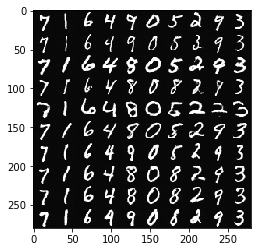

In [64]:
plt.imshow(convertDataToImage(t.evaluation(seed=123), 10, 10), cmap='gray')

In [54]:
a = np.array(t.metrics[0])

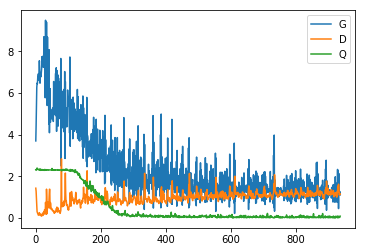

In [55]:
plt.plot(a[:,0], label='G')
plt.plot(a[:,1], label='D')
plt.plot(a[:,2], label='Q')
plt.legend()

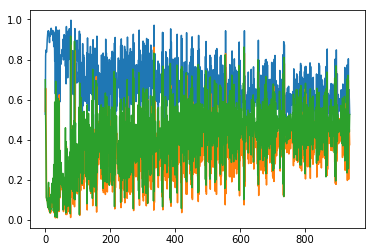

In [56]:
plt.plot(a[:,3])
plt.plot(a[:,4])
plt.plot(a[:,5])